In [1]:
from PIL import Image
import cv2
import numpy as np
import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scripts.inference_i2mv_sdxl import (
    run_pipeline,
    prepare_pipeline
)

/home/sheongee/miniconda3/envs/mvadapter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
NUMVIEWS = 4
azimuth_deg = [i*(360/NUMVIEWS) for i in range(NUMVIEWS)]
DEVICE = "cuda"

pipe = prepare_pipeline(
	base_model = "stabilityai/stable-diffusion-xl-base-1.0",
	vae_model = "madebyollin/sdxl-vae-fp16-fix",
	adapter_path = "huanngzh/mv-adapter",
    unet_model = None,
    lora_model = None,
    scheduler = None,
	num_views=NUMVIEWS,
	device=DEVICE,
	dtype=torch.float16,
)


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.48it/s]


In [5]:
pipe = pipe.to(DEVICE)

In [10]:
def my_custom_callback(pipeline, step, timestep, callback_kwargs):
    """매 타임스텝마다 실행되는 사용자 정의 callback 함수"""
    print(f"Step {step}: Timestep {timestep}")

    latent = callback_kwargs.get("latents", None)
    if latent is None:
        return callback_kwargs
    
    # 이미지를 PIL 형식으로 변환
    def save_image_tensor(latents, path):
        latents = latents / pipeline.vae.config.scaling_factor
        with torch.no_grad():
            image_tensors = pipeline.vae.decode(latents.to(pipeline.device)).sample  # [B, C, H, W]
        images = []
        for img in image_tensors:
            img = (img / 2 + 0.5).clamp(0, 1)  # Normalize to [0, 1]
            img = (img * 255).byte().permute(1, 2, 0).cpu().numpy()  # [H, W, C]로 변환
            img_pil = Image.fromarray(img)
            images.append(img_pil)
        
        # 여러 개의 이미지가 있으면 그리드로 저장
        os.makedirs(path, exist_ok=True)
        if len(images) > 1:
            image_grid = make_image_grid(images, rows=1)  # 기존 코드와 동일한 방식
            img_path = os.path.join(path, f"{step}.png")
            image_grid.save(img_path)
        else:
            img_path = os.path.join(path, f"{step}.png")
            images[0].save(img_path)
    
    SAVE_DIR = "out_0"

    #save_image_tensor(latent, f"{SAVE_DIR}_xt")
    #save_image_tensor(pred_x0, f"{SAVE_DIR}_x0")

    return callback_kwargs

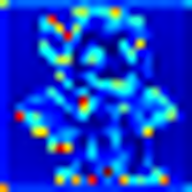

 94%|█████████▍| 47/50 [09:59<00:35, 11.98s/it]

In [ ]:
IMAGE = "assets/demo/i2mv/dino.png"

images, reference_image = run_pipeline(
    pipe,
    num_views=NUMVIEWS,
    text="",
    image=IMAGE,
    height=768,
    width=768,
    num_inference_steps=50,
    guidance_scale=3.0,
    seed=21,
    lora_scale=1.0,
    reference_conditioning_scale=1.0,
    negative_prompt="watermark, ugly, deformed, noisy, blurry, low contrast",
    device=DEVICE,
    remove_bg_fn=None,
    azimuth_deg=azimuth_deg,
)

In [30]:
from mvadapter.utils import (
    draw_patches,
    make_image_grid
)

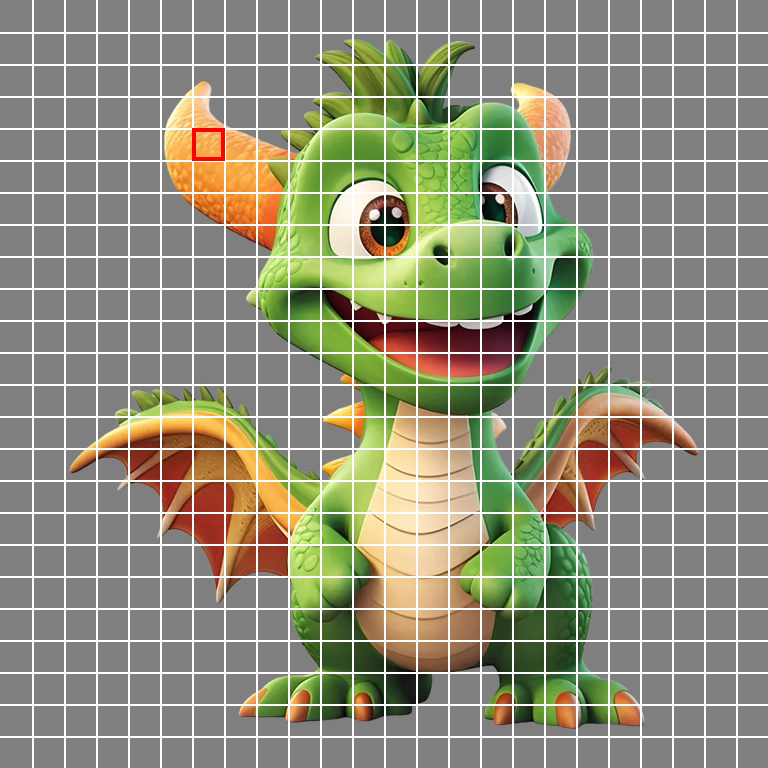

In [58]:
display(draw_patches(reference_image, num_patches=(24, 24), highlight_index=102))

In [ ]:
display(draw_patches(images[3], num_patches=(24, 24), highlight_index=102))

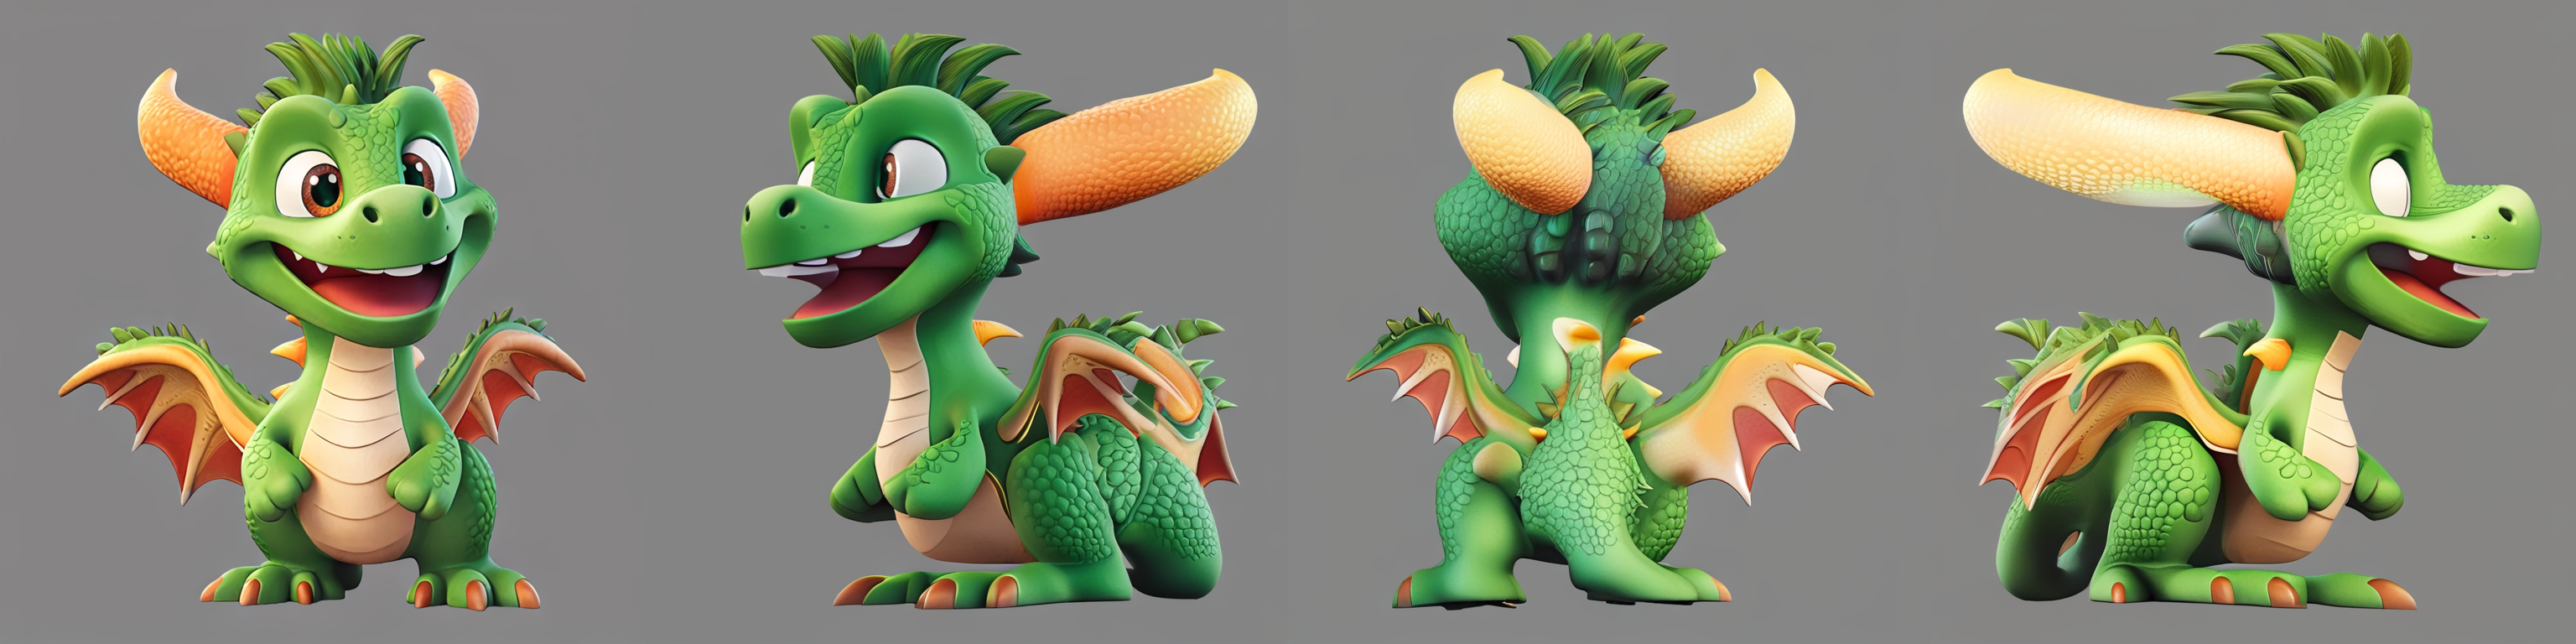

In [29]:
display(make_image_grid(images, rows=1))